In [1]:
pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import pandas as pd
import pytesseract
from sklearn.model_selection import train_test_split

2025-05-15 17:53:51.891518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-15 17:53:51.891679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-15 17:53:52.042329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set paths for input and output folders
originalImage = "/kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.bmp" 
imageMask = "/kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.xml"      
fileSavepath = "/kaggle/working/final_data/"                                    
table_mask_path = "/kaggle/working/final_data/tablemask/"                        
col_mask_path = "/kaggle/working/final_data/colmask/"                            
org_image_path = "/kaggle/working/final_data/orgimage/"                          
dataPath = "/kaggle/input/marmot-extended/Marmot_data/"                          
model = "/kaggle/working/model"                                                  

# Create directories if they don't exist
os.makedirs(fileSavepath, exist_ok=True)
os.makedirs(table_mask_path, exist_ok=True)
os.makedirs(col_mask_path, exist_ok=True)
os.makedirs(org_image_path, exist_ok=True)
os.makedirs(model, exist_ok=True)

# Print paths for confirmation
print("originalImage path:", originalImage)
print("imageMask path:", imageMask)
print("fileSavepath path:", fileSavepath)
print("table_mask_path path:", table_mask_path)
print("col_mask_path path:", col_mask_path)
print("org_image_path path:", org_image_path)
print("dataPath path:", dataPath)
print("model path:", model)


originalImage path: /kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.bmp
imageMask path: /kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.xml
fileSavepath path: /kaggle/working/final_data/
table_mask_path path: /kaggle/working/final_data/tablemask/
col_mask_path path: /kaggle/working/final_data/colmask/
org_image_path path: /kaggle/working/final_data/orgimage/
dataPath path: /kaggle/input/marmot-extended/Marmot_data/
model path: /kaggle/working/model


In [4]:
image_xml_dict = {"image_path":[], "xml_path":[]}

for file in os.listdir(dataPath):
  if ".bmp" in file:
    name = file.split(".bmp")[0]
    if os.path.exists(dataPath+name+".xml"):
      image_xml_dict['image_path'].append(name+".bmp")
      image_xml_dict['xml_path'].append(name+".xml")


image_xml_df = pd.DataFrame(image_xml_dict)

image_xml_df.head(2)

,image_path,xml_path
0,10.1.1.6.2260_4.bmp,10.1.1.6.2260_4.xml
1,10.1.1.1.2034_8.bmp,10.1.1.1.2034_8.xml


In [5]:
def euc_dist(point1, point2):
    dist = np.linalg.norm(point1 - point2)
    return dist

def show_image_plt(image_arr):
  plt.figure(figsize=(5,5))
  plt.imshow(image_arr)
  plt.show()

def save_image(name, image_arr):
  im = Image.fromarray(image_arr)
  im.save(name)


final_dataframe_dict = {"image":[], "table_mask":[], "col_mask":[]}

for index, row in image_xml_df.iterrows():


    # per row --> xml_path
    org_img_mask_xml = row['xml_path'] # .xml path
    image = dataPath + row['image_path'] # image .bmp path

    # file name
    name = org_img_mask_xml.split(".xml")[0]
    

    # reading xml file
    tree = ET.parse(dataPath + org_img_mask_xml)
    root = tree.getroot()


    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    depth = int(size.find('depth').text)

    # creating empty mask image
    col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
    table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

  # finding objects
    objects = tree.findall('object')
    table_xmin = 0
    table_ymin = 0
    table_xmax = 0
    table_ymax = 0
    prev_dist = 0
    dist = 0
    forward_flag = False
    backward_flag = False
    newtable_flag = True

    objects = tree.findall('object')

    for index, object in enumerate(objects):
        
        bndbox = object.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        
        col_mask_empty[ymin:ymax, xmin:xmax] = 255
        
        
        
        if index == 0:
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            
            
        else:  
                
            
            if xmin > prev_xmin and newtable_flag:
                

                table_xmin = prev_xmin
                table_ymin = prev_ymin
                newtable_flag = False
                forward_flag = True
                backward_flag = False

            if xmin < prev_xmin and newtable_flag:
                
                
                table_xmax = prev_xmax
                table_ymax = prev_ymax
                
                
                newtable_flag = False
                backward_flag = True
                forward_flag = False



            if forward_flag:
                dist = euc_dist(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:

                    if int(np.divide(dist, prev_dist)) > 5:
                        newtable_flag = True
                        table_mask_empty[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255

                        prev_dist = 0
                        
                    if index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[table_ymin:ymax, table_xmin:xmax] = 255

                        prev_dist = 0

            if backward_flag:
                dist = euc_dist(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:
                    if int(np.divide(dist, prev_dist)) > 5 or index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[ymin:table_ymax, xmin:table_xmax] = 255
                        prev_dist = 0
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            prev_dist = dist
            

    save_image(table_mask_path+ name+".jpeg", table_mask_empty)
    save_image(col_mask_path + name+".jpeg", col_mask_empty)

    final_dataframe_dict['table_mask'].append(table_mask_path+ name+".jpeg")
    final_dataframe_dict['col_mask'].append(col_mask_path + name+".jpeg")
    final_dataframe_dict['image'].append(image)



# creating dataframe --> (oroginal_image, table_mask, col_mask)
final_dataframe = pd.DataFrame(final_dataframe_dict)
final_dataframe.head(2)
final_dataframe.to_csv("/kaggle/working/final_data/final_dataframe.csv", index=False)

In [6]:
final_dataframe = pd.read_csv("/kaggle/working/final_data/final_dataframe.csv")
final_dataframe.head(2)

,image,table_mask,col_mask
0,/kaggle/input/marmot-extended/Marmot_data/10.1...,/kaggle/working/final_data/tablemask/10.1.1.6....,/kaggle/working/final_data/colmask/10.1.1.6.22...
1,/kaggle/input/marmot-extended/Marmot_data/10.1...,/kaggle/working/final_data/tablemask/10.1.1.1....,/kaggle/working/final_data/colmask/10.1.1.1.20...


In [7]:
X_train, X_test = train_test_split(final_dataframe, test_size=0.2)

In [8]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train['image'].values, tf.string),
            tf.cast(X_train['table_mask'].values, tf.string),
            tf.cast(X_train['col_mask'].values, tf.string),
        )
    )
)



testing_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test['image'].values, tf.string),
            tf.cast(X_test['table_mask'].values, tf.string),
            tf.cast(X_test['col_mask'].values, tf.string),
        )
    )
)

In [9]:
@tf.function
def load_image(image, table_mask, col_mask):

    image = tf.io.read_file(image)
    table_mask=tf.io.read_file(table_mask)
    col_mask=tf.io.read_file(col_mask)

    image=tf.io.decode_bmp(image, channels=3)
    image=tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0

    table_mask=tf.io.decode_jpeg(table_mask, channels=1)
    table_mask=tf.image.resize(table_mask, [512, 512])
    table_mask = table_mask / 255.0
    

    col_mask=tf.io.decode_jpeg(col_mask, channels=1)
    col_mask=tf.image.resize(col_mask, [512, 512])
    col_mask = col_mask / 255.0

    return image, {"table_mask":table_mask, "col_mask":col_mask}



# creating dataset object
train = training_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = testing_dataset.map(load_image)

In [10]:
BATCH_SIZE = 8
BUFFER_SIZE = 10
train_steps = len(X_train) // BATCH_SIZE

# for feeding to training
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

(512, 512, 3)
(512, 512, 1)
(512, 512, 1)


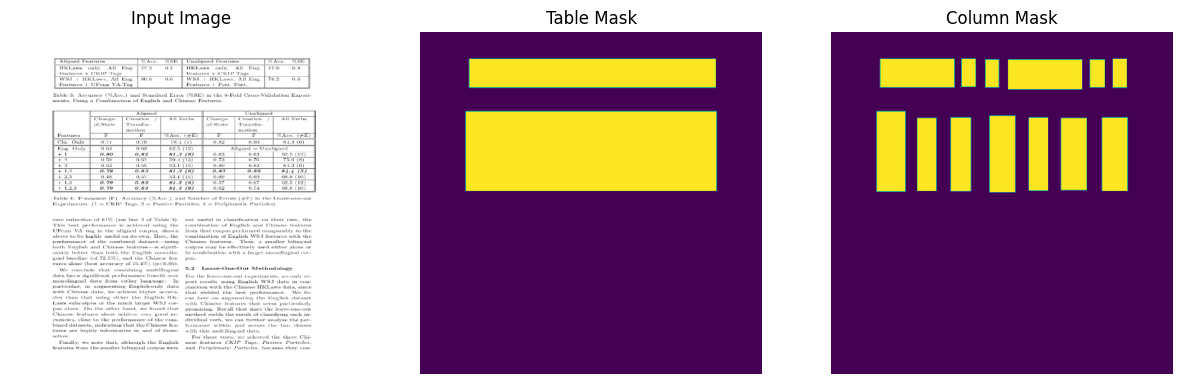

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Table Mask', 'Column Mask', 'Masked image']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        image = display_list[i]

        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
        plt.axis('off')
    plt.show()



for image, mask in train.take(1):

    sample_image = image
    sample_table_mask = mask['table_mask']
    sample_col_mask = mask['col_mask']


    print(image.shape)
    print(mask['table_mask'].shape)
    print(mask['col_mask'].shape)
    display([image, mask['table_mask'], mask['col_mask']])

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization

In [15]:
K.clear_session()

class table_mask(Layer):
    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.002))
        self.bn_7 = BatchNormalization()
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        x = self.conv_7(input)
        x = self.bn_7(x)
        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        x = self.upsample_final(x)
        return x


class col_mask(Layer):
    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal')
        self.bn_7 = BatchNormalization()
        self.drop = Dropout(0.8)
        self.conv_8 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal')
        self.bn_8 = BatchNormalization()
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        x = self.conv_7(input)
        x = self.bn_7(x)
        x = self.drop(x)
        x = self.conv_8(x)
        x = self.bn_8(x)
        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        x = self.upsample_final(x)
        return x


input_shape = (512, 512, 3)
input_ = Input(shape=input_shape)

vgg19_ = VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

for layer in vgg19_.layers:
    layer.trainable = False

pool3 = vgg19_.get_layer('block3_pool').output
pool4 = vgg19_.get_layer('block4_pool').output

# conv_1_1_1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv1", kernel_regularizer=tf.keras.regularizers.l2(0.004))(vgg19_.output)
# conv_1_1_1_drop = Dropout(0.8)(conv_1_1_1)

# conv_1_1_2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv2", kernel_regularizer=tf.keras.regularizers.l2(0.004))(conv_1_1_1_drop)
# conv_1_1_2_drop = Dropout(0.8)(conv_1_1_2)
conv_1_1_1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv1", kernel_regularizer=tf.keras.regularizers.l2(0.004))(vgg19_.output)
conv_1_1_1 = BatchNormalization()(conv_1_1_1)
conv_1_1_1_drop = Dropout(0.8)(conv_1_1_1)

conv_1_1_2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv2", kernel_regularizer=tf.keras.regularizers.l2(0.004))(conv_1_1_1_drop)
conv_1_1_2 = BatchNormalization()(conv_1_1_2)
conv_1_1_2_drop = Dropout(0.8)(conv_1_1_2)
table_mask = table_mask()(conv_1_1_2_drop, pool3, pool4)
col_mask = col_mask()(conv_1_1_2_drop, pool3, pool4)

model = Model(input_, [table_mask, col_mask])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 512, 512,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 256, 256,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 256, 256,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 256, 256,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 128, 128,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 128, 128,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 128, 128,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 128, 128,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 128, 128,  │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 64, 64,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 64, 64,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 64, 64,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 64, 64,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 64, 64,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 32, 32,    │          0 │ block4_conv4[0][

 Total params: 20,190,916 (77.02 MB)

 Trainable params: 165,252 (645.52 KB)

 Non-trainable params: 20,025,664 (76.39 MB)

In [16]:
losses = {
    "table_mask": 'sparse_categorical_crossentropy',
    "col_mask": 'sparse_categorical_crossentropy',
}

# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

filepath = '/kaggle/working/model/my_model_2.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = "val_table_mask_loss", save_best_only=True, verbose = 0, mode="min",save_weights_only=True)

checkpoint_manager = tf.train.CheckpointManager(
    model_checkpoint,
    directory = '/kaggle/working/my_model_chechpoints',
    max_to_keep = 3)

if checkpoint_manager.latest_checkpoint:
    checkpint.restore(checkpoint_manager.latest_checkpoint)
    print("Restored from checkpoint:",checkpoint_manager.latest_checkpoint)
    
    checkpoint_manager.save(checkpoint_number=epoch)
    print("Saved checkpoint for epoch:", epoch)



es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,)


class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, tf.argmax(y_pred, axis=-1))
        r = self.recall_fn(y_true, tf.argmax(y_pred, axis=-1))
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

# Define metrics for each output
metrics = {
    "table_mask": ['accuracy', F1_Score(name='f1_score_table')],
    "col_mask": ['accuracy', F1_Score(name='f1_score_col')],
}

global init_lr
init_lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr, epsilon=1e-8,),
              loss=losses,
              metrics=metrics)

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.history = {'val_table_mask_loss':[]}
        self.init_lr = init_lr

    def on_epoch_end(self, epoch, logs=None):
        # if epoch % 10 == 0:
        #     show_predictions(test_dataset, 1)

        # Get the current loss value
        current_val_loss = logs.get('val_table_mask_loss')

        # Append the current loss to the history only if it's not None
        if current_val_loss is not None:
            self.history['val_table_mask_loss'].append(current_val_loss)

            # Ensure there are enough elements in the history before accessing
            if len(self.history['val_table_mask_loss']) > 1:
                cur_loss = self.history['val_table_mask_loss'][-1]
                prev_loss = self.history['val_table_mask_loss'][-2]

                if cur_loss is not None and prev_loss is not None and cur_loss > prev_loss:
                    self.init_lr = self.init_lr * 0.93
                    K.set_value(self.model.optimizer.learning_rate, self.init_lr)

In [21]:
# Train the model
EPOCHS = 20
VAL_SUBSPLITS = 30
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=test_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=[model_checkpoint, es, DisplayCallback()]
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - col_mask_accuracy: 0.8475 - col_mask_f1_score_col: 0.2895 - loss: 4.4190 - table_mask_accuracy: 0.8507 - table_mask_f1_score_table: 0.4716 - val_col_mask_accuracy: 0.8507 - val_col_mask_f1_score_col: 0.3715 - val_loss: 3.9598 - val_table_mask_accuracy: 0.8683 - val_table_mask_f1_score_table: 0.4902
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - col_mask_accuracy: 0.8600 - col_mask_f1_score_col: 0.3951 - loss: 3.8022 - table_mask_accuracy: 0.8775 - table_mask_f1_score_table: 0.5639 - val_col_mask_accuracy: 0.8672 - val_col_mask_f1_score_col: 0.4185 - val_loss: 3.5715 - val_table_mask_accuracy: 0.8806 - val_table_mask_f1_score_table: 0.5106
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 720ms/step - col_mask_accuracy: 0.8729 - col_mask_f1_score_col: 0.4587 - loss: 3.4260 - table_mask_accuracy: 0.8930 - table_mask_f1_score_table: 0.6281 - val_col_mask_accuracy: 0.8748 - val_col_mask_f1_score_col: 0.4512 - val_loss: 3.2762 - val_tab

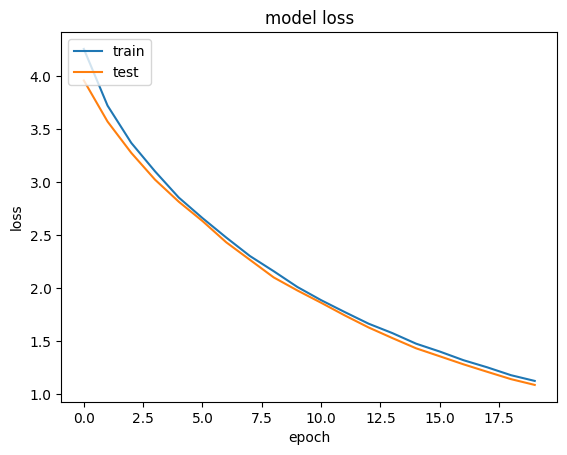

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Save the full model
model.save('/kaggle/working/table_column_segmentation_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Extracted Table Text:
 Es

—

2

tlt

il

et

ao |


Extracted Column Text:
 ET

-

I

et ; iT

I

Il

i

]

l

lt

|

il

lf



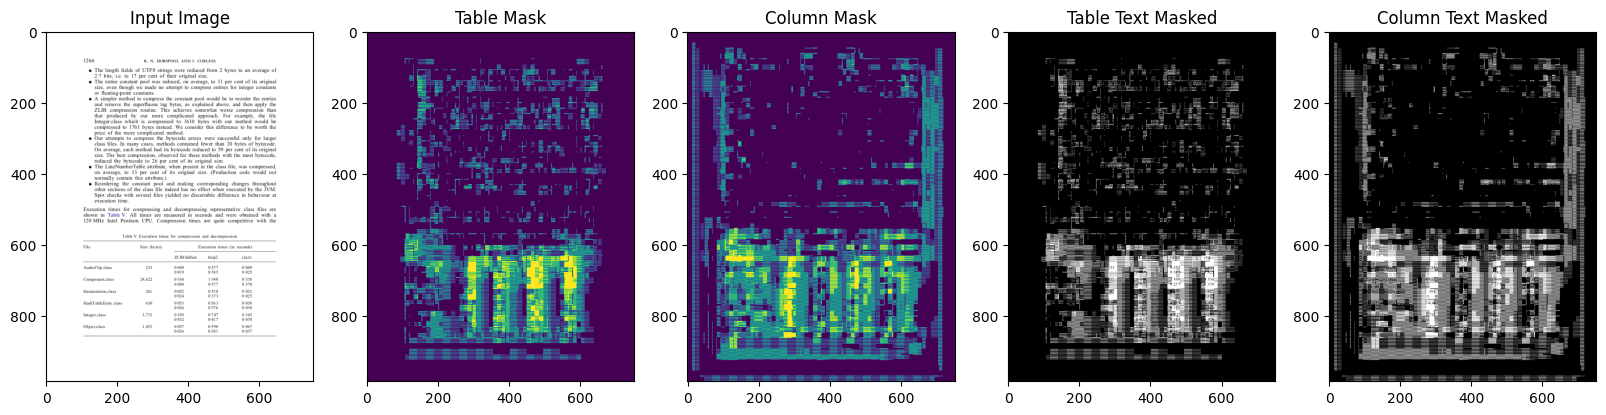

In [27]:
# --- Predict and extract masks ---
def predict_and_extract(model, image):
    image_resized = cv2.resize(image, (512, 512))
    image_resized = np.expand_dims(image_resized, axis=0)
    
    table_mask_pred, col_mask_pred = model.predict(image_resized)
    table_mask = np.argmax(table_mask_pred[0], axis=-1)
    col_mask = np.argmax(col_mask_pred[0], axis=-1)
    
    table_mask_resized = cv2.resize(table_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    col_mask_resized = cv2.resize(col_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    return table_mask_resized, col_mask_resized

# --- Clean and apply mask + extract text ---
def extract_text_from_mask(image, mask, psm=11):
    # Convert to binary mask
    binary_mask = (mask > 0).astype(np.uint8) * 255

    # Convert to grayscale and apply mask
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    masked = cv2.bitwise_and(gray, gray, mask=binary_mask)

    # Optional: Thresholding (improves OCR)
    _, thresh = cv2.threshold(masked, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # OCR
    text = pytesseract.image_to_string(thresh, config=f'--psm {psm}')
    return text, thresh

# --- Optional visualization with contours ---
def show_mask_overlay(image, mask, title="Mask"):
    contours, _ = cv2.findContours((mask > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay = image.copy()
    cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# --- Run the pipeline ---
image_path = '/kaggle/input/table1111/table1.bmp'
image = cv2.imread(image_path)

if image is None:
    print("Failed to load image.")
else:
    # Predict table and column masks
    table_mask, col_mask = predict_and_extract(model, image)

    # Extract text
    table_text, table_masked_image = extract_text_from_mask(image, table_mask, psm=11)
    col_text, col_masked_image = extract_text_from_mask(image, col_mask, psm=11)

    # Display extracted text
    print("Extracted Table Text:\n", table_text)
    print("\nExtracted Column Text:\n", col_text)

    # Plot all outputs
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Input Image')

    plt.subplot(1, 5, 2)
    plt.imshow(table_mask, cmap='viridis')
    plt.title('Table Mask')

    plt.subplot(1, 5, 3)
    plt.imshow(col_mask, cmap='viridis')
    plt.title('Column Mask')

    plt.subplot(1, 5, 4)
    plt.imshow(table_masked_image, cmap='gray')
    plt.title('Table Text Masked')

    plt.subplot(1, 5, 5)
    plt.imshow(col_masked_image, cmap='gray')
    plt.title('Column Text Masked')

    plt.show()
